# Gradient Estimation in Stochastic Computation Graphs

## Introduction

In this IPython Notebook, we aim at exploring different ways to **estimate gradients** in stochastic computation graphs in order to optimize an objective function defined by an expectation over a set of random variables.

In terms of implementation, we'll use the TensorFlow library, mainly because of its automatic reverse-mode differentiation capabilities.

The notation and theory are based on the following NIPS paper:
<blockquote>
Schulman, J., Heess, N., Weber, T. and Abbeel, P., 2015.<br>
**[Gradient estimation using stochastic computation graphs](http://papers.nips.cc/paper/5899-gradient-estimation-using-stochastic-computation-graphs.pdf).**<br>
In Advances in Neural Information Processing Systems (pp. 3528-3536).
</blockquote>

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import utils

%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Stochastic Computation Graphs

A stochastic computation graph is a DAG (directly acyclic graph) defined over 3 different type of nodes:
- *input nodes*: the parameters one wants to estimate the gradient with respect to;
- *deterministic nodes*: representing deterministic dependencies on their parents (i.e., a function); and
- *stochastic nodes*: representing random variables distributed conditionally on their parents.

In this notebook, we will consider the following simple stochastic computation graph as a running example:
![scg1](files/img/scg1.png)

This stochastic computation graph encodes the expected loss:
$$
\begin{equation}
\mathcal{L}(\theta) = \mathbb{E}_{y~\sim~p(\cdot~|~x(\theta))} [ f(y) ]
\end{equation}
$$

Our overall goal is to estimate the gradient $\nabla_{\theta} \mathcal{L}$ in order to minimize the objective $\mathcal{L}$ by stochastic gradient descent.

Let's define the deterministic and stochastic dependencies in order to have a concrete example:

$$
\begin{align}
\theta &\in [-\infty, +\infty] \\
x(\theta) &= \text{sigmoid}(\theta) = \frac{1}{1+e^{-\theta}} \\
y &\sim \mathcal{N}(\mu=x + 0.5, \sigma=|2x - 1|) \\
f(y) &= y(y - 2) \\
\end{align}
$$

Let's inspect how all these dependencies fit together:

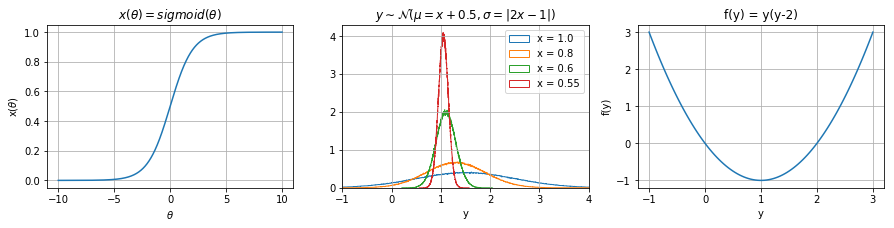

In [2]:
fig = plt.figure(figsize=(15, 3))

# input parameter theta and deterministic function x(theta)
theta = np.linspace(-10, 10, 1000)
x = 1.0 / (1.0 + np.exp(-theta))
plt.subplot(131)
plt.plot(theta, x)
plt.title('$x(\\theta) = sigmoid(\\theta)$')
plt.xlabel('$\\theta$')
plt.ylabel('x($\\theta$)')
plt.grid()

# random variable y distributed conditionally on x
plt.subplot(132)
for x in [1.0, 0.8, 0.6, 0.55]:
    y = np.random.normal(loc=x + 0.5, scale=np.abs(2 * x - 1), size=(1000000))
    plt.hist(y, bins=1000, histtype='step', normed=True, label='x = {}'.format(x))
    plt.xlim(-1, 4)
plt.title('$y\sim\mathcal{N}(\mu=x + 0.5, \sigma=|2x-1|)$')
plt.xlabel('y')
plt.grid()
plt.legend()

# deterministic function f(y)
y = np.linspace(-1, 3, 100)
f = y * (y - 2)
plt.subplot(133)
plt.plot(y, f)
plt.title('f(y) = y(y-2)')
plt.xlabel('y')
plt.ylabel('f(y)')
plt.grid()

From this visual inspection, it should be clear that by decreasing the standard deviation of $y$ and at the same time getting the mean close to $1.0$, we'll be able to minimize the expected value of $f(y)$, since $argmin_y f(y) = 1.0$.

So, to achieve this mininum value, it seems that we should simply set the input parameter $x$ to $0.5$, which correspond to set $\theta$ to $0.0$.

In summary, with this simple convex example we can build an analytical solution to the optimization problem, which will serve as a baseline to debug the code in next sections.

## Define the stochastic computation graph

First of all, we need to build the computation graph in TensorFlow. Note that we've defined the input parameter as a placeholder so as to evaluate $\mathcal{L}(\theta)$ as a function of $\theta$.

In [3]:
graph = tf.Graph()

with graph.as_default():

    theta = tf.placeholder(shape=(), dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.abs(2*x - 1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(100000), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

Let's estimate $\mathcal{L}(\theta)$ by running our graph in a session:

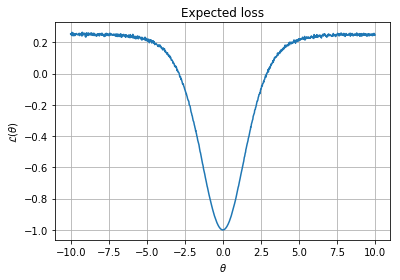

In [4]:
with tf.Session(graph=graph) as sess:

    losses = []
    theta_values = np.linspace(-10.0, 10.0, 1000)
    for theta_value in theta_values:
        expected_loss = sess.run(loss, feed_dict={theta: theta_value})
        losses.append(expected_loss)

# plot expected loss as a function of theta
plt.plot(theta_values, losses)
plt.title('Expected loss')
plt.ylabel('$\mathcal{L}(\\theta)$')
plt.xlabel('$\\theta$')
plt.grid()

As it can be seen from the chart above, our initial hypothesis is correct: setting $\theta = 0.0$ indeed minimizes the expected loss $\mathcal{L}$.

## Estimating the loss gradient directly from stochastic graph

As a first attempt, let's add the necessary operations in our model to run stochastic gradient desccent in order to optimize $\mathcal{L}(\theta)$.

In [5]:
graph = tf.Graph()

with graph.as_default():

    theta = tf.Variable(initial_value=-1.0, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.abs(2*x - 1, name="sigma")
    y = tf.distributions.Normal(loc=mu, scale=sigma).sample(sample_shape=(100000), name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
    init = tf.global_variables_initializer()

Let's run gradient descent over a number of epochs to see if we can find the global minimum.

In [6]:
with tf.Session(graph=graph) as sess:
    
    sess.run(init)
    
    theta_values = []
    losses = []
    for epoch in range(1000):
        
        # evaluate graph
        theta_, loss_ = sess.run([theta, loss])
        theta_values.append(theta_)
        losses.append(loss_)
        
        # optimize parameter
        sess.run(train_step)

        if epoch % 10 == 0:
            print('epoch = {}, theta = {}, loss = {}\r'.format(epoch, theta_, loss_), end='')

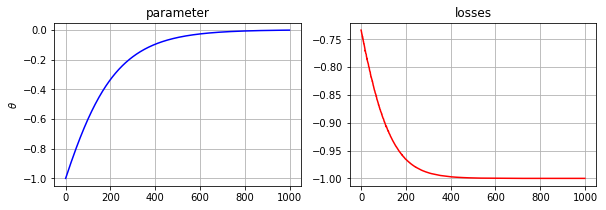

In [7]:
utils.plot_results(theta_values, losses)

## Re-parameterization trick

Let's use the re-parameterization trick to extract out the random variable in order to sample it out of our model.

![scg2](files/img/scg2.png)

This stochastic computation graph encodes the expected loss:
$$
\mathbb{E}_{\xi \sim \mathcal{N}(0.0, 1.0)} [f(y(x, \xi))]
$$
where $y(x, \xi) = \mu(x) + \sigma(x)\xi$.

In [8]:
graph = tf.Graph()

with graph.as_default():

    theta = tf.Variable(initial_value=-1.0, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    noise = tf.placeholder(tf.float32, shape=(100000), name="noise")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.abs(2*x - 1, name="sigma")
    y = tf.add(mu, sigma * noise, name="y")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
    init = tf.global_variables_initializer()

In [9]:
with tf.Session(graph=graph) as sess:
    
    sess.run(init)
    
    theta_values = []
    losses = []
    for epoch in range(1000):
        
        # evaluate graph
        noise_ = np.random.normal(loc=0.0, scale=1.0, size=(100000))
        theta_, loss_ = sess.run([theta, loss], feed_dict={noise: noise_})
        theta_values.append(theta_)
        losses.append(loss_)
        
        # optimize parameter
        sess.run(train_step, feed_dict={noise: noise_})

        if epoch % 10 == 0:
            print('epoch = {}, theta = {}, loss = {}\r'.format(epoch, theta_, loss_), end='')

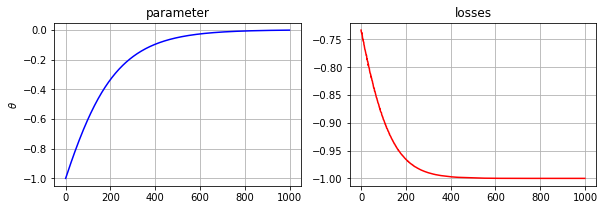

In [10]:
utils.plot_results(theta_values, losses)

## Likelihood ratio estimator

Let's implement a **surrogate loss function** that takes into consideration the likelihood ratio in the gradient estimation.

![scg3](files/img/scg3.png)

In [11]:
graph = tf.Graph()

with graph.as_default():

    theta = tf.Variable(initial_value=-1.0, dtype=tf.float32, name="theta")
    x = tf.sigmoid(theta, name="x")

    mu = tf.add(x, 0.5, name="mu")
    sigma = tf.abs(2*x - 1, name="sigma")
    p_y = tf.distributions.Normal(loc=mu, scale=sigma, name='p_y')

    y = p_y.sample(sample_shape=(100000), name="y")
    log_prob = p_y.log_prob(y, name="log_prob")

    f = tf.multiply(y, y-2, name="f")
    loss = tf.reduce_mean(f, name="loss")

    surrogate_loss = tf.reduce_mean(f * log_prob, name="surrogate_loss")

    train_step = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(surrogate_loss)
    init = tf.global_variables_initializer()

In [12]:
with tf.Session(graph=graph) as sess:
    
    sess.run(init)
    
    theta_values = []
    losses = []
    surrogate_losses = []
    for epoch in range(1000):
        
        # evaluate graph
        theta_, loss_, surrogate_loss_ = sess.run([theta, loss, surrogate_loss])
        theta_values.append(theta_)
        losses.append(loss_)
        surrogate_losses.append(surrogate_loss_)
        
        # optimize parameter
        sess.run(train_step)

        if epoch % 10 == 0:
            print('epoch = {}, theta = {}, loss = {}\r'.format(epoch, theta_, loss_), end='')

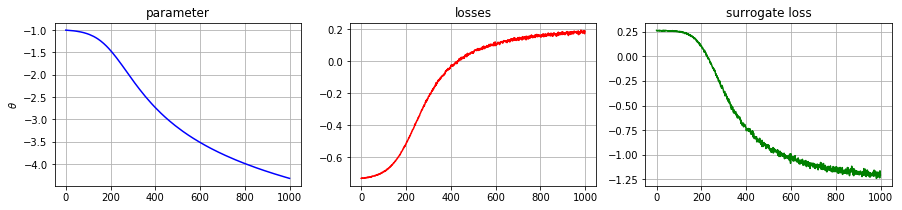

In [13]:
utils.plot_results(theta_values, losses, surrogate_losses)